# Dissociation of a water dimer with BigDFT

This notebook is divided in two parts. 

The first one presents how to obtain the last figure presented in the BigDFT tutorial on the dissociation of a water dimer using the fragment approach with a jupyter notebook.

The second part is about comparing the results obtained for a similar system, where a water molecule has been replaced by a OH molecule, and a charge added to the system (while this charge may be constrained on the OH molecule).

###### First, let the notebook be aware of the BigDFT module
To do that, the simplest way is to source the bigdftvars.sh script as indicated in the [corresponding webpage](http://bigdft.org/Wiki/index.php?title=Prepare_the_environment) of BigDFT website. So if you did not do so, reopen the notebook server in the correct environment.

In [1]:
#write here the position of the BigDFT installation (usually <buildtree>/install/lib/pythonX.X/site-packages)
import os
BIGDFT_PYTHONDIR=os.path.abspath(
    '/Users/maximemoriniere/post-doc/bigdft/bigdft/bigdft/src/python'
    ) #refer to the sources, only for test 
#then update the path
import sys
if BIGDFT_PYTHONDIR not in sys.path: 
    sys.path+=[BIGDFT_PYTHONDIR]

###### Import useful modules

In [2]:
from BigDFT import Logfiles as lf 
from futile import Yaml
from futile.Utils import find_files
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tarfile
#for interactive plots remove the following line
%matplotlib inline 

###### Definition of functions used to treat the data.

In [3]:
def _load_logfiles_from_archive(paths, archive):
    """
    This function loads the Logfiles instances 
    from the list of paths leading to files in archive.
    
    :param paths: paths leading to logfiles in the archive
    :type paths: list of strings
    :param archive: path to the tarfile
    :type archive: string
    :returns: loaded logfiles as dictionaries
    :rtype: list
    """
    import tarfile
    with tarfile.open(archive) as arch:
        logfiles = []
        #Loop over the paths to read each logfile as a dictionary
        #and append them to the list logfiles
        for path in paths:
            filetar = arch.extractfile(path)
            content = filetar.read()
            dictionary = Yaml.yaml.load(stream=content)
            logfiles.append(lf.Logfile(dictionary=dictionary))
        return logfiles


def load_logfiles(paths, archive=None):
    """
    Returns a list of logfiles given their paths
    and an optional archive where they are stored
    (if no archive given, then look for files from the
    current working directory).
    
    :param paths: paths leading to logfiles
    :type paths: list of strings
    :param archive: path to the tarfile (default to None)
    :type archive: string
    :returns: loaded logfiles as dictionaries
    :rtype: list
    """
    if archive is not None:
        return _load_logfiles_from_archive(paths, archive)
    else:
        return [lf.Logfile(path) for path in paths]

    
def distance(atoms, positions):
    """
    Calculate the distance between two atoms given the 
    positions of all atoms of the system.
    The ID of the atoms is given by a list of two integers.
    
    :param positions: list of all atoms in the system (each atom 
                      corresponding to a dict).
    :type positions: list
    :param atoms: list of two integers giving, the position (in positions) 
                  of the atoms for which we want to know the distance.
    :type atoms: list
    :returns: distance between the two atoms
    :rtype: float
    :raises: ValueError if the length of the list is not equal to 2
    """
    
    if len(atoms) != 2 and isinstance(atoms, list):
        raise ValueError(
            "The length of the list of atoms must equal to 2.")
    
    
    # Find the position of both atoms
    pos = [] # List that will contain both atom positions
    for at in atoms:
        ##print("at", at, "positions", positions)
        dico = positions[at]     #Find an atom dico
        element = dico.keys()[0] #Find the element
        ##print("dico", dico, "element", element)
        pos.append(np.array(dico[element])) #append the positions
        
    # Compute and return the distance between the atoms
    diff = pos[0] - pos[1]
    return np.sqrt(diff.dot(diff))


def shift_energies(energies, shift):
    """
    Function that shifts down all energies by the value of shift.
    
    :param energies: list of energies
    :type energies: list
    :param shift: value of the shift
    :type shift: float
    :returns: shifted energies
    :rtype: list
    
    :Example:
    >>> shift_energies([10.0, 5.0], 5.0)
    [5.0, 0.0]
    """
    
    en_len = len(energies)
    return [energies[i]-([shift]*en_len)[i] for i in range(en_len)]


def Ha_to_eV(energies):
    """
    Converts each energy in the list energies from Hartree to eV.
    
    :param energies: energies in Hartree
    :type: list
    :returns: energies in eV
    :rtype: list
    
    :Example:
    >>> Ha_to_eV([0.1, 0.2])
    [2.7211396132, 5.4422792264]
    """
    return [ en*27.211396132 for en in energies]


def find_data(regexp, legend, archive=None):
    """
    Given a regexp to find the logfiles in a given archive, 
    this function collects the data needed to plot
    dissociation curves, e.g. distance vs energy.
    The data is made of the distances between the two water 
    molecules and the total energies of the corresponding dimers.
    A legendtitle is also added to the dictionnary, in order to 
    be used as legend for the plots.
    
    :param regexp: regular expression leading to logfiles
    :type regexp: str
    :param legend: legend of the dissociation curve
    :type legend: str
    :param archive: path to the tarfile where logfiles are stored
                    (default to None, indicating to look for)
    :type archive: str
    :returns: all necessary data to plot a dissociation curve,
              e.g. distance vs energy (including all the logfiles 
              as dictionaries, in case one needs to re-use them
              without re-loading them).
    :rtype: dict
    :raises: ValueError if the regexp leads to no logfiles
    """
    
    print(legend)
    data = {'legend': legend}
    paths = find_files(regexp, archive=archive)
    #print(paths)
    data['logfiles'] = load_logfiles(paths, archive=archive)
    if len(data['logfiles']) < 1:
        raise ValueError("No logfiles found, try a new regexp.")
    # Find the distance between the two molecules
    data['distances'] = [distance([2, 3], log.astruct['Positions']) 
                         for log in data['logfiles']]
    # Sort the logfiles according to the distances first
    data['logfiles'] = [log for (dist, log) in 
                        sorted(zip(data['distances'], data['logfiles']))]
    # Sort the distances
    data['distances'] = sorted(data['distances'])
    # The energies are listed for increasing distance
    data['energies'] = [log.energy for log in data['logfiles']]
    # Shift the energies and convert them to eV
    ref = data['energies'][-1] #reference value at large distance
    data['energies'] = Ha_to_eV(shift_energies(data['energies'], ref))
    
    return data

###### Definition of functions to read input files and return a dictionary of differences and print it

In [4]:
def merge_dicts(d1, d2, path=None):
    """
    Returns a modified dictionary d1 built as the merge of the 
    two (possibly nested) dictionaries d1 and d2.
    
    :param d1: The first dictionary, modified by the function
    :param d2: The second dictionary.
    :type d1: dict
    :type d2: dict
    :return: The result of the merge of d1 and d2
    :rtype: dict
    :raises: ValueError
    """
    
    #The idea of this function is to set d1 as the reference
    #and loop (recursively) over the keys of d2 to copy in d1
    #any key-value pair that is not in d1.
    #There is a conflict if a key has two differents
    
    #Initialize path
    if path is None: path = []
    
    #Loop over the keys in d2
    for key in d2:
        
        #If the key is not in d1, we found something to add
        if key not in d1:
            d1[key] = d2[key]
        
        #Otherwise:
        # 1- First try the recursion of merge_dicts. 
        # 2- If it fails, it means that either d1[key] or 
        #    d2[key] is not a dictionary. We therefore compare 
        #    these values:
        #    a) If the values are the same, there is nothing to do.
        #    b) However, if the values are different, then 
        #       there is a conflict: d1 and d2 cannot be merged.
        else:
            #Try the recursion
            try:
                merge_dicts(d1[key], d2[key], path + [str(key)])
            #It fails if at least d1[key] or d2[key] is not a dict
            except TypeError:
                if d1[key] == d2[key]:
                    pass # same value, no need to update
                else:
                    #the two values are different, there is a conflict
                    raise ValueError('Conflict at {}'\
                                .format('.'.join(path + [str(key)])))
        
    return d1

###Tests for merge_dicts
##d1={'a': 1, 'b': 2}
##d2={'c': 3, 'd': 4}
##print(merge_dicts(d1, d2))
##print(d1, d2)
##print()
##print()
##d1={'lin_basis': {'O': {'nbasis': 5}}}
##d2={'lin_basis': {'H': {'nbasis': 2}}}
##print(merge_dicts(d1, d2))
##print(d1, d2)
##print()
##print()


def create_nested_dict(keys, val):
    """
    Create a nested dict from the list keys, 
    with the last value being val.
    
    :param keys: list of keys
    :type keys: list
    :param val: the value associated to the last key in keys 
    :type val: any object
    
    :Example:
    
    >>> create_nested_dict(['a', 'b'], [1, None])
    >>> {'a': {'b': [1, None]}}
    """
    
    #Initialization
    new_keys = list(keys) #to leave keys unchanged
    new_dict = {}
    new_keys.reverse()
    last_key = new_keys.pop(0)
    new_dict[last_key] = val
    #print(new_dict)
    
    #Loop over all the other elements to nest the previous
    #dictionary in a new one.
    for key in new_keys:
        #Copy the previous dictionary under the new key
        new_dict[key] = new_dict.copy()
        #Delete the dictionary that has been copied
        del new_dict[last_key]
        #Update the value of last_key
        last_key = key
        
    return new_dict


def update(diff, keys, val):
    """
    Updates the dictionary of difference diff, given 
    a list of keys and a value (value must be a list of length 2). 
    The last two arguments help defining a nested dictionary, 
    which is finally merged to diff.
    
    :param diff: dictionary of differences between two dictionaries
    :type diff: dict
    :param keys: list of keys leading to different values
    :type keys: list
    :param val: a list of the different values between two dictionaries
    :type val: list of length 2
    """
    
    #Make sure val is a list of length 2
    try:
        isinstance(val, list)
        len(val) == 2
    except Exception as e:
        print(e)
        print("val must be a list of lenght 2.")
        print("Its wrong value is: {}".format(val))
        
    #create a new nested dictionary
    new_dict = create_nested_dict(keys, val)
    #return a merged dictionary
    return merge_dicts(new_dict, diff)


def diff_dict_from_path(path1, path2, verbosity=True):
    """
    Wrapps the function diff_dict so that two
    paths to yaml files are given. These two files are read
    as dictionaries and then sent to diff_dict, with the paths 
    as names of the dictionaries (used in diff_dict if verbosity=True).
    
    :param path1: path to the first file
    :param path2: path to the second file
    :type path1: str
    :type path2: str
    :param verbosity: Forces the printing of the differences found
    :param verbosity: boolean
    """
    d1 = Yaml.yaml.load(open(path1, 'r').read())
    d2 = Yaml.yaml.load(open(path2, 'r').read())
    print('Difference(s) between {} and {}'.format(path1, path2))
    return diff_dict(d1, d2, verbosity=verbosity, 
                     name1=path1, name2=path2)

    
def diff_dict(d1, d2, diff={}, keys=[], 
              verbosity=True, count=-1, name1="d1", name2="d2"):
    """
    Function taking two dictionaries as input and returning 
    a dictionary of differences (and printing the differences if
    verbosity is set to True).
    
    All differences are stored as values of the dictionary diff.
    These values are lists of length 2, the first (resp. second) 
    element being the value of the first (resp. second) dictionary.
    If one key is not found in one of the dictionary,
    its value is set to None in the list of values.
    
    :param d1: first dictionary
    :type d1: dict
    :param d2: second dictionary
    :type d2: dict
    :param diff: the difference dictionary (default: {}), recursively updated.
    :type diff: dict
    :param keys: list of keys leading to the difference, recursively updated.
    :type keys: list
    :param verbosity: Forces the printing of the differences found.
    :type verbosity: boolean
    :param count: value counting the number of recursions (default -1). Used when verbosity=True.
    :type count: int
    :param name1: name of the first dictionary (default "d1"). Used when verbosity=True.
    :type name1: str
    :param name2: name of the second dictionary (default "d2"). Used when verbosity=True.
    :type name2: str
    """
    
    #The goal of this function is to find the differences between
    #two (possibly nested) dictionaries and store them into diff,
    #whichis a dictionary. 
    #There are three possible differences:
    # 1- A key is in d1, but not in d2: 
    #    Append this key to keys, update diff, and remove it from keys
    # 2- A key is in d2, but not in d1: 
    #    Append this key to keys, update diff, and remove it from keys
    # 3- A key is in d1 and d2, but the values are different:
    #   Append this key to keys
    #   a) Try recursion of diff_dict first.
    #   b) If it raises a TypeError (meaning d1[key] or d2[key] is 
    #      not a dict), then we found a difference: update diff.
    #   Finally remove the key from keys
    
    #Initialization
    if verbosity:
        #print("keys", keys)
        sep="  "           #text separator
        prefix = sep*count #prefix of the message to be printed
        if keys != []:
            print(prefix+"Changes in {}:".format(keys[-1]))
        else:
            count = -1 #make sure count is correctly initialized
        prefix = sep*(count+1) #reset the prefix
        
    #Loop over all the keys in d1
    for key in d1:
        #If one key is missing in d2, then update diff
        if key not in d2:
            keys.append(key) #update the keys list
            try:
                diff = update(diff, keys, [d1[key], None])
            finally:
                keys.pop(-1) #remove the last element of the keys list
            if verbosity:
                #Print what is missing, with two different cases:
                #1- if this is the first call of diff_dict
                if count == -1:
                    print(prefix+"Changes in {}:".format(key))
                    print(prefix+sep+"++ {}: {}    #{}"\
                          .format(key, d1[key], name1))           
                #2- all other cases
                else:
                    print(prefix+"++ {}: {}    #{}"\
                          .format(key, d1[key], name1))
            
    #Loop over the keys in d2
    for key in d2:
        #If one key is missing in d1, then update diff
        if key not in d1:
            keys.append(key) #update the keys list
            try:
                diff = update(diff, keys, [None, d2[key]])
            finally:
                keys.pop(-1) #remove the last element of the keys list
            if verbosity:
                #Print what is missing, with two different cases:
                #1- if this is the first call of diff_dict
                if count == -1:
                    print(prefix+"Changes in {}:".format(key))
                    print(prefix+sep+"++ {}: {}    #{}"\
                          .format(key, d2[key], name2))         
                #2- all other cases
                else:
                    print(prefix+"++ {}: {}    #{}"\
                          .format(key, d2[key], name2))
            
        #We are now sure that the key is in both dicts,
        #it is time to compare their values.
        elif d2[key] != d1[key]:
            keys.append(key) #update the keys list
            #Try the recursion of diff_dict
            try:
                diff = diff_dict(d1[key], d2[key], count=count+1, 
                                 name1=name1, name2=name2, 
                                 diff=diff, keys=keys, 
                                 verbosity=verbosity)
            #If one of the two values is not a dict, it raises a 
            #TypeError. This means that a difference is found, 
            #and diff has to be updated.
            except TypeError:
                diff = update(diff, keys, [d1[key], d2[key]])
                ##print(diff)
                if verbosity:
                    print(prefix+"** {}: {}    #{}"\
                          .format(key, d1[key], name1))
                    print(prefix+"** {}: {}    #{}"\
                          .format(key, d2[key], name2))
            finally:
                #print("keys[-1]", keys[-1])
                keys.pop(-1) #remove the last element of the keys list
    return diff

## Dissociation of a water dimer : the BigDFT fragment tutorial

The goal of this exercice is to test the fragment approach of BigDFT and to compare the results against the one obtained using the cubic and the linear versions of BigDFT. This is [*the last exercise of the BigDFT fragment tutorial*](http://bigdft.org/Wiki/index.php?title=Fragment_approach). The studied problem is the dissociation curve of a H2O dimer, the key parameter being the distance between the two water molecules (this distance is defined by the distance between the oxygen atom of one water molecule and the closest hydrogen atom of the other molecule; for all the calculations, the orientations of the water molecules stay the same, so that only a molecule is translated in the different input files).

We have put in the tarfile 'dissociation.tar.gz' the archive of all the logfiles which have been used for the present study.

In [5]:
# Define the archive to look for, if needed.
archive = 'dissociation.tar.gz' # Comment this line if you have untarred the archive.
archive = None # Comment this line if you have not untarred the archive.

Let us now extract the files corresponding to each of the run classes.
We have defined the *find\_data* function so that it returns a python dictionary containg everything we need to plot the data for one class. Each dictionnary has four keys, associated to a value:
* the key 'legend' is associated to a string value, that will be used as a legend when plotting.
* the key 'logfiles', associated to a list of logfiles, sorted so that the distance between the two water molecules is increasing.
* the key 'distances', associated to a numpy array of distances,
* the key 'energies', associated to a numpy array of the corresponding energies.

The numbers inside the parenthesis for the linear and fragments calculations correspond to the *nbasis* parameter used for the H and O atoms, respectively.

In [6]:
# Open the logfiles according to the regexp and treat the data
cubic    = find_data("H2O/cubic/dimer*/log-*yaml", 'Cubic', archive=archive)
lin_1_4  = find_data("H2O/linear_1-4/dimer*/log-*yaml", 'Linear (1, 4)', archive=archive)
frag_1_4 = find_data("H2O/fragment_1-4/dimer*/log-*yaml", 'Fragment (1, 4)', archive=archive)
frag_2_5 = find_data("H2O/fragment_2-5/dimer*/log-*yaml", 'Fragment (2, 5)', archive=archive)
frag_5_8 = find_data("H2O/fragment_5-8/dimer*/log-*yaml", 'Fragment (5, 8)', archive=archive)

Cubic
Linear (1, 4)
Fragment (1, 4)
Fragment (2, 5)
Fragment (5, 8)


It is then easy to plot the data, and reproduce the [*plot obtained in the last exercise of the tutorial*](http://bigdft.org/images/b/b1/H2o_binding.png). The explanation is given [*in this article, section II.F*](http://dx.doi.org/10.1063/1.4922378).

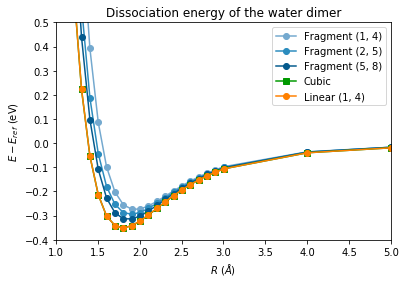

In [7]:
# List of data to be plotted
curves = [frag_1_4, frag_2_5, frag_5_8, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.4, 0.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Test of the influence of some input parameters
It is now easy to test the influence of some input parameters on these dissociation curves.

### *nbasis*
A key parameter is the number of support functions per atom type, *nbasis*. Increasing this parameters allows for the inclusion of polarization effects of the charge density due to the presence of a neighboring molecule, therefore reducing the basis set superposition error.

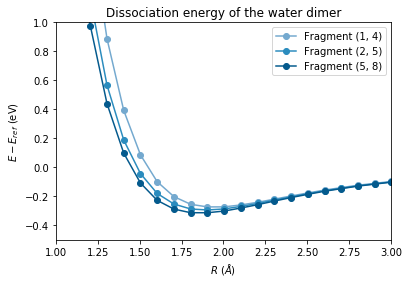

In [8]:
# List of data to be plotted
curves = [frag_1_4, frag_2_5, frag_5_8]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

#### Differences in the input files

In [9]:
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/fragment_2-5/dimer.yaml")
print()
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/fragment_5-8/dimer.yaml")
print()
diff_dict_from_path("H2O/fragment_2-5/dimer.yaml", "H2O/fragment_5-8/dimer.yaml")

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/fragment_2-5/dimer.yaml
Changes in ig_occupation:
  ++ ig_occupation: {'H': {'1s': 1.0, '2s': 0.0}, 'O': {'3s': 0.0, '2p': ['4/3', '4/3', '4/3'], '2s': 2.0}}    #H2O/fragment_2-5/dimer.yaml
Changes in lin_basis_params:
  Changes in H:
    Changes in nbasis:
    ** nbasis: 1    #H2O/fragment_1-4/dimer.yaml
    ** nbasis: 2    #H2O/fragment_2-5/dimer.yaml
  Changes in O:
    Changes in nbasis:
    ** nbasis: 4    #H2O/fragment_1-4/dimer.yaml
    ** nbasis: 5    #H2O/fragment_2-5/dimer.yaml

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/fragment_5-8/dimer.yaml
Changes in ig_occupation:
  ++ ig_occupation: {'H': {'1s': 1.0, '2p': [0.0, 0.0, 0.0], '2s': 0.0}, 'O': {'3s': 0.0, '3p': [0.0, 0.0, 0.0], '2p': ['4/3', '4/3', '4/3'], '2s': 2.0}}    #H2O/fragment_5-8/dimer.yaml
Changes in lin_basis_params:
  Changes in H:
    Changes in nbasis:
    ** nbasis: 1    #H2O/fragment_1-4/dimer.yaml
    ** nbasis: 5    #H2O/fragment_5-8

{'ig_occupation': {'H': {'2p': [None, [0.0, 0.0, 0.0]]},
  'O': {'3p': [None, [0.0, 0.0, 0.0]]}},
 'lin_basis_params': {'H': {'nbasis': [2, 5]}, 'O': {'nbasis': [5, 8]}}}

### *rloc* parameters 
We test here the value of the three rloc parameters. Their meaning is introduced in the lin_basis_parameters section [*here*](http://bigdft.org/Wiki/index.php?title=Input_variables).

Increasing them should give more accurate results, and this is the case here: a convergence with respect to these parameters is reached when the tutorial values are used (increasing them gives the same result).

In [10]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_1_4_small_rlocs = find_data("H2O/templates_tests/H2O/test7/H2O-dimer/dimer*/log-*yaml",
                                 'Fragment (1, 4) small rlocs (6, 8, 10)', archive=archive)

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_1_4_large_rlocs = find_data("H2O/templates_tests/H2O/test5/H2O-dimer/dimer*/log-*yaml",
                                 'Fragment (1, 4) large rlocs (11, 14, 16)', archive=archive)

Fragment (1, 4) small rlocs (6, 8, 10)
Fragment (1, 4) large rlocs (11, 14, 16)


In [11]:
#Change the legend for the tutorial calculation frag_1-4
frag_1_4['legend'] = 'Fragment (1, 4) medium rlocs (9, 12, 14) [tuto]'

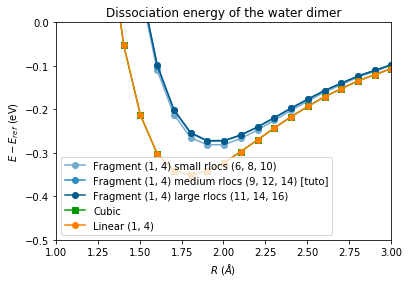

In [12]:
# Chose the dissociation curves to be plotted
curves = [frag_1_4_small_rlocs, frag_1_4, 
          frag_1_4_large_rlocs, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.5, 0.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

#### Differences in the input files

In [13]:
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test5/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml", 
                    "H2O/templates_tests/H2O/test5/H2O-dimer/dimer.yaml")

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
Changes in lin_basis_params:
  Changes in H:
    Changes in rloc_kernel_foe:
    ** rloc_kernel_foe: 14.0    #H2O/fragment_1-4/dimer.yaml
    ** rloc_kernel_foe: 10.0    #H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
    Changes in rloc:
    ** rloc: 9.0    #H2O/fragment_1-4/dimer.yaml
    ** rloc: 6.0    #H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
    Changes in rloc_kernel:
    ** rloc_kernel: 12.0    #H2O/fragment_1-4/dimer.yaml
    ** rloc_kernel: 8.0    #H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
  Changes in O:
    Changes in rloc_kernel_foe:
    ** rloc_kernel_foe: 14.0    #H2O/fragment_1-4/dimer.yaml
    ** rloc_kernel_foe: 10.0    #H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
    Changes in rloc:
    ** rloc: 9.0    #H2O/fragment_1-4/dimer.yaml
    ** rloc: 6.0    #H2O/templates_tests/H2O/test7/H2O-dimer/dimer.yaml
    Changes in rloc_kernel:
    

{'lin_basis_params': {'H': {'rloc': [6.0, 11.0],
   'rloc_kernel': [8.0, 14.0],
   'rloc_kernel_foe': [10.0, 16.0]},
  'O': {'rloc': [6.0, 11.0],
   'rloc_kernel': [8.0, 14.0],
   'rloc_kernel_foe': [10.0, 16.0]}}}

### *rloc* parameters when increasing *nbasis*
The influence of the *rloc* is the same for larger values of *nbasis*.

In [14]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_5_8_small_rloc = find_data("H2O/templates_tests/H2O/test9/H2O-dimer/dimer*/log-*yaml",
                                'Fragment (5, 8) small rlocs (6, 8, 10)', archive=archive)

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_5_8_large_rloc = find_data("H2O/templates_tests/H2O/test8/H2O-dimer/dimer*/log-*yaml",
                               'Fragment (5, 8) large rlocs (11, 14, 16)', archive=archive)

Fragment (5, 8) small rlocs (6, 8, 10)
Fragment (5, 8) large rlocs (11, 14, 16)


In [15]:
#Change the legend for the tutorial calculation frag_5_8
frag_5_8['legend'] = 'Fragment (5, 8) rlocs (9, 12, 14) [tuto]'

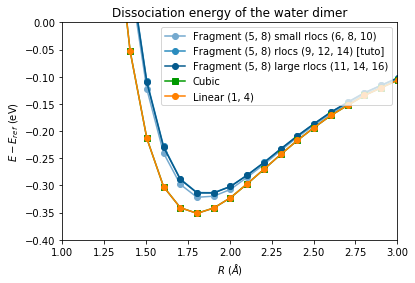

In [16]:
# Chose the dissociation curves to be plotted
curves = [frag_5_8_small_rloc, frag_5_8, 
          frag_5_8_large_rloc, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.4, 0.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend(loc=1)
plt.show()

#### Differences in the input files

In [17]:
diff_dict_from_path("H2O/fragment_5-8/dimer.yaml", "H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/fragment_5-8/dimer.yaml", "H2O/templates_tests/H2O/test8/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml", 
                    "H2O/templates_tests/H2O/test8/H2O-dimer/dimer.yaml")

Difference(s) between H2O/fragment_5-8/dimer.yaml and H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
Changes in lin_basis_params:
  Changes in H:
    Changes in rloc_kernel_foe:
    ** rloc_kernel_foe: 14.0    #H2O/fragment_5-8/dimer.yaml
    ** rloc_kernel_foe: 10.0    #H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
    Changes in rloc:
    ** rloc: 9.0    #H2O/fragment_5-8/dimer.yaml
    ** rloc: 6.0    #H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
    Changes in rloc_kernel:
    ** rloc_kernel: 12.0    #H2O/fragment_5-8/dimer.yaml
    ** rloc_kernel: 8.0    #H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
  Changes in O:
    Changes in rloc_kernel_foe:
    ** rloc_kernel_foe: 14.0    #H2O/fragment_5-8/dimer.yaml
    ** rloc_kernel_foe: 10.0    #H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
    Changes in rloc:
    ** rloc: 9.0    #H2O/fragment_5-8/dimer.yaml
    ** rloc: 6.0    #H2O/templates_tests/H2O/test9/H2O-dimer/dimer.yaml
    Changes in rloc_kernel:
    

{'lin_basis_params': {'H': {'rloc': [6.0, 11.0],
   'rloc_kernel': [8.0, 14.0],
   'rloc_kernel_foe': [10.0, 16.0]},
  'O': {'rloc': [6.0, 11.0],
   'rloc_kernel': [8.0, 14.0],
   'rloc_kernel_foe': [10.0, 16.0]}}}

### *crmult* and *frmult* parameters
Another key parameters are the grid extensions [*crmult* and *frmult*](http://bigdft.org/Wiki/index.php?title=Basis-set_convergence#crmult.2C_frmult). The values (*crmult*, *frmult*) = (5.0, 7.0) used in the tutorial already give converged results with respect to the grid extensions. 

In [18]:
#Small rlocs (rloc, rloc_foe, rloc_foe_kernel) = (6, 8, 10)
frag_1_4_medium_rm = find_data("H2O/templates_tests/H2O/test3/H2O-dimer/dimer*/log-*yaml",
                               'Fragment (1, 4) crm 7, frm 8', archive=archive)

#Large rlocs (rloc, rloc_foe, rloc_foe_kernel) = (11, 14, 16)
frag_1_4_large_rm = find_data("H2O/templates_tests/H2O/test4/H2O-dimer/dimer*/log-*yaml",
                              'Fragment (1, 4) crm 9, frm 8', archive=archive)

Fragment (1, 4) crm 7, frm 8
Fragment (1, 4) crm 9, frm 8


In [19]:
#Change the legend for the tutorial calculation frag_1-4
frag_1_4['legend'] = 'Fragment (1, 4) crm 5, frm 7 [tuto]'

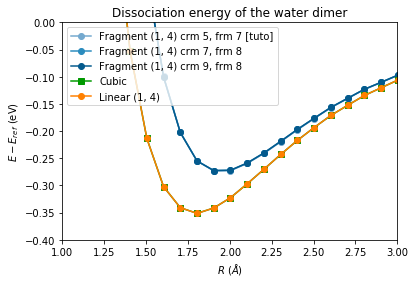

In [20]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_medium_rm, 
          frag_1_4_large_rm, cubic, lin_1_4]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.4, 0.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

#### Differences in the input files

In [21]:
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml")
print()
diff_dict_from_path("H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml", 
                    "H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml")

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml
Changes in dft:
  Changes in rmult:
  ** rmult: [5.0, 7.0]    #H2O/fragment_1-4/dimer.yaml
  ** rmult: [7.0, 8.0]    #H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml
Changes in dft:
  Changes in rmult:
  ** rmult: [5.0, 7.0]    #H2O/fragment_1-4/dimer.yaml
  ** rmult: [9.0, 8.0]    #H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml

Difference(s) between H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml and H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml
Changes in dft:
  Changes in rmult:
  ** rmult: [7.0, 8.0]    #H2O/templates_tests/H2O/test3/H2O-dimer/dimer.yaml
  ** rmult: [9.0, 8.0]    #H2O/templates_tests/H2O/test4/H2O-dimer/dimer.yaml


{'dft': {'rmult': [[7.0, 8.0], [9.0, 8.0]]}}

### confinement or not in h2o.yaml and dimer.yaml
This test is about the inclusion or not of two parameters (*ao_confinement* and *confinement*) in the input files. The energies are higer without the confinement for large distances (but close to the results obtaind usingconfinement), while there is a sharp change around 1.75 $\unicode[serif]{xC5}$.

In [22]:
#no confinement
frag_1_4_no_conf = find_data("H2O/templates_tests/H2O/test1/H2O-dimer/dimer*/log-*yaml",
                               'Fragment (1, 4) without confinement', archive=archive)

Fragment (1, 4) without confinement


In [23]:
#Change the legend for the tutorial calculation frag_1-4 and frag_2_5
frag_1_4['legend'] = 'Fragment (1, 4) with confinement [tuto]'
frag_5_8['legend'] = 'Fragment (5, 8) with confinement [tuto]'

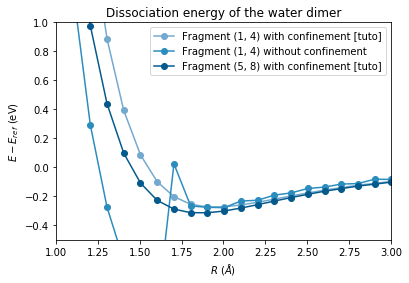

In [24]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_no_conf, frag_5_8]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

#### Differences in the input files

In [25]:
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test1/H2O-dimer/dimer.yaml")

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/templates_tests/H2O/test1/H2O-dimer/dimer.yaml
Changes in lin_basis_params:
  Changes in H:
    ++ confinement: [0.005, 0.0]    #H2O/fragment_1-4/dimer.yaml
    ++ ao_confinement: 0.01    #H2O/fragment_1-4/dimer.yaml
  Changes in O:
    ++ confinement: [0.005, 0.0]    #H2O/fragment_1-4/dimer.yaml
    ++ ao_confinement: 0.01    #H2O/fragment_1-4/dimer.yaml


{'lin_basis_params': {'H': {'ao_confinement': [0.01, None],
   'confinement': [[0.005, 0.0], None]},
  'O': {'ao_confinement': [0.01, None], 'confinement': [[0.005, 0.0], None]}}}

### remove *nit* and *rpnrm_cv* from the dimer.yaml input files
This test is about the importance of "nit: 1" (in lin_basis and lin_kernel) and "rpnrm_cv: 1.0E-010" (in lin_kernel) in the input files. The results are close to the one obtained in the previous test for short distances, except that the sharp change occurs at a distance around 2.0 $\unicode[serif]{xC5}$. Actually, the two "wrong" results are in better agreement at small distance than at high distance. 

In [26]:
#no confinement
frag_1_4_no_nit = find_data("H2O/templates_tests/H2O/test2/H2O-dimer/dimer*/log-*yaml",
                               'Fragment (1, 4) without nit and rpnrm_cv', archive=archive)

Fragment (1, 4) without nit and rpnrm_cv


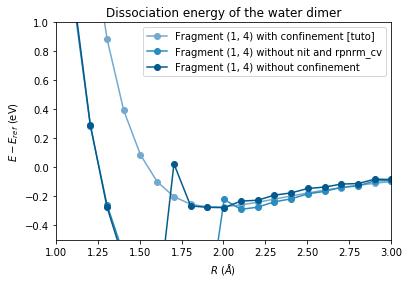

In [27]:
# List of data to be plotted
curves = [frag_1_4, frag_1_4_no_nit, frag_1_4_no_conf]
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
markers = ['o']*3+['s']+['o']
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
plt.ylim([-0.5, 1.0])
plt.xlim([1.0, 3.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

#### Differences in the input files

In [28]:
diff_dict_from_path("H2O/fragment_1-4/dimer.yaml", "H2O/templates_tests/H2O/test2/H2O-dimer/dimer.yaml")

Difference(s) between H2O/fragment_1-4/dimer.yaml and H2O/templates_tests/H2O/test2/H2O-dimer/dimer.yaml
Changes in lin_basis:
  ++ lin_basis: {'nit': 1}    #H2O/fragment_1-4/dimer.yaml
Changes in lin_kernel:
  ++ rpnrm_cv: 1e-10    #H2O/fragment_1-4/dimer.yaml
  ++ nit: [20, 100]    #H2O/fragment_1-4/dimer.yaml


{'lin_basis': [{'nit': 1}, None],
 'lin_kernel': {'nit': [[20, 100], None], 'rpnrm_cv': [1e-10, None]}}

## Dissociation of a H$_2$O - HO$^-$ dimer

In this part of the notebook, the system under study has the same number of electrons as before, but is lacking a hydrogen atom. Cubic simulations have been done (no full linear simulations yet) as well as fragment approach simulations.

The goal of this part of the notebook is to illustrate how to use constrained DFT in the fragment approach with BigDFT. Two initial setups were used: one using OH as a template, the other using OH$^-$ as the template. Constrained DFT can be applied on top of that, in order to force the added electron to remain in the OH fragment.

In [29]:
# Open the logfiles according to the regexp and treat the data
cubic_OHm = find_data("OH-/cubic/r-*/log-*yaml", 'Cubic OH$^-$', archive=archive)
OHm       = find_data("OH-/oh-/r-*/log-*yaml", 'OH$^-$', archive=archive)
OHm_CDFT  = find_data("OH-/oh-_CDFT/r-*/log-*yaml", 'OH$^-$ (CDFT)', archive=archive)
OH_m      = find_data("OH-/oh_-1/r-*/log-*yaml", 'OH + $e^-$', archive=archive)
OH_m_CDFT = find_data("OH-/oh_-1_CDFT/r-*/log-*yaml", 'OH + $e^-$ (CDFT)', archive=archive)

Cubic OH$^-$
OH$^-$
OH$^-$ (CDFT)
OH + $e^-$
OH + $e^-$ (CDFT)


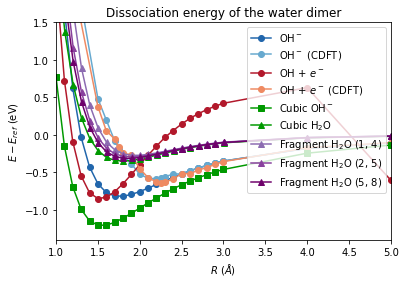

In [30]:
# List of data to be plotted
curves = [OHm, OHm_CDFT, OH_m, OH_m_CDFT, 
          cubic_OHm, cubic, frag_1_4, frag_2_5, frag_5_8]
#Change the legendtitle of the cubic plot
cubic['legend'] = 'Cubic H$_2$O'
frag_1_4['legend'] = 'Fragment H$_2$O (1, 4)'
frag_2_5['legend'] = 'Fragment H$_2$O (2, 5)'
frag_5_8['legend'] = 'Fragment H$_2$O (5, 8)'
# Lists of markers and colors (for matplotlib)
colors = ['#2166ac', '#67a9cf', '#b2182b', '#ef8a62', '#009900', '#009900', '#8c6bb1', '#88419d', '#6e016b']
markers = ['o']*4+['s']+['^']*4
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.4, 1.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

### Some tests of convergence

#### Effect of the *nbasis* parameter (and also for larger *crmult* and *frmult*)
Here is tested the influence of the nbasis parameter on the dissociation curves when the fragments OH or OH- are used. The influence of the *crmult* and *frmult* parameters is also tested for different *nbasis*.

##### Case of the OH- fragment with CDFT (electron constrained on the OH)
One sees that, again, the *crmult* and *frmult* factors have no influence on the results obtained (except that it is almost impossible to get a result in a reasonable computational time for the larger basis sets). 
In contrast to the water dimer case, there is no convergence when *nbasis* is increased. It even seems more difficult for the two molecules to bind. 

For all the *nbasis* parameters, the long distance trend stays the same. However, the short distance energies diverge at short distances, and the point where they start diverging gets larger as *nbasis* is increased (up to $R = 2.2~\unicode[serif]{xC5}$ for *nbasis* = (2,5); up to $R = 3.0~\unicode[serif]{xC5}$ for *nbasis* = (5,8)).

In [31]:
archive = None
# Open the logfiles according to the regexp and treat the data
OHm_CDFT_2_5_small_rm = find_data("OH-/oh-_CDFT/templates_variations/test4/dimer_*/log-*yaml", 
                                  'OH$^-$ (2, 5) crm 5, frm 7 (CDFT)', archive=archive)
OHm_CDFT_5_8_small_rm = find_data("OH-/oh-_CDFT/templates_variations/test3/dimer_*/log-*yaml", 
                                  'OH$^-$ (5, 8) crm 5, frm 7 (CDFT)', archive=archive)
OHm_CDFT_1_4_medium_rm = find_data("OH-/oh-_CDFT/templates_variations/test1/dimer_*/log-*yaml", 
                                  'OH$^-$ (1, 4) crm 7, frm 8 (CDFT)', archive=archive)
OHm_CDFT_5_8_medium_rm = find_data("OH-/oh-_CDFT/templates_variations/test2/dimer_*/log-*yaml", 
                                  'OH$^-$ (5, 8) crm 7, frm 8 (CDFT)', archive=archive)

OH$^-$ (2, 5) crm 5, frm 7 (CDFT)
OH$^-$ (5, 8) crm 5, frm 7 (CDFT)
OH$^-$ (1, 4) crm 7, frm 8 (CDFT)
OH$^-$ (5, 8) crm 7, frm 8 (CDFT)


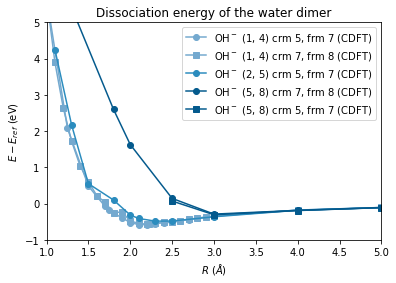

In [32]:
# List of data to be plotted
## curves = [OHm_CDFT, OHm_CDFT_1_4_large_rm]
## curves = [OHm_CDFT, OHm_CDFT_1_4_large_rm, OHm_CDFT_5_8_large_rm]
curves = [OHm_CDFT, OHm_CDFT_1_4_medium_rm, OHm_CDFT_2_5_small_rm, OHm_CDFT_5_8_medium_rm, OHm_CDFT_5_8_small_rm]
#update legend
OHm_CDFT['legend'] = 'OH$^-$ (1, 4) crm 5, frm 7 (CDFT)'
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#74a9cf', '#2b8cbe', '#045a8d', '#045a8d']
markers = ['o', 's', 'o', 'o', 's']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.0, 5.0])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

##### Case of the OH fragment with CDFT (electron constrained on the OH)

The same trend is experienced using the OH fragment with constrained DFT for the extra charge to remain on the OH fragment. However, even for the small grid extensions, it gets difficult to reach a convergence of the calcultation for small distances $R$ as nbasis in increased.

In [33]:
archive=None
# Open the logfiles according to the regexp and treat the data
OH_m_CDFT_2_5_small_rm = find_data("OH-/oh_-1_CDFT/templates_variations/test2/dimer_*/log-*yaml", 
                                  'OH + $e^-$ (2, 5) crm 5, frm 7 (CDFT)', archive=archive)
OH_m_CDFT_5_8_small_rm = find_data("OH-/oh_-1_CDFT/templates_variations/test1/dimer_*/log-*yaml", 
                                  'OH + $e^-$ (5, 8) crm 5, frm 7 (CDFT)', archive=archive)#

OH + $e^-$ (2, 5) crm 5, frm 7 (CDFT)
OH + $e^-$ (5, 8) crm 5, frm 7 (CDFT)


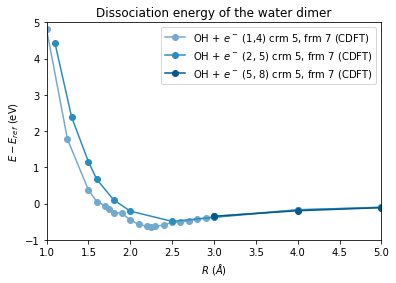

In [34]:
# List of data to be plotted
curves = [OH_m_CDFT, OH_m_CDFT_2_5_small_rm, OH_m_CDFT_5_8_small_rm]
#curves = [OH_m_CDFT, OH_m_CDFT_2_5_small_rm]
#updat legend
OH_m_CDFT['legend'] = 'OH + $e^-$ (1,4) crm 5, frm 7 (CDFT)'
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d']
markers = ['o']*4+['s']+['^']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.0, 5.0])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

###### Vary *nbasis* for the OH- fragment without CDFT

This set of calculations exhibit the behaviour of the fragment approach without the Constrained DFT as *nbasis* is increased. In the same manner as in the water dimer case, there is a convergence to the cubic results as this parameter is increased.

In [35]:
archive = None
OHm_2_5 = find_data("OH-/oh-/template_tests/nb_2-5/dimer_*/log-*yaml", 'OH$^-$ (2,5)', archive=archive)
OHm_5_8 = find_data("OH-/oh-/template_tests/nb_5-8/dimer_*/log-*yaml", 'OH$^-$ (5,8)', archive=archive)

OH$^-$ (2,5)
OH$^-$ (5,8)


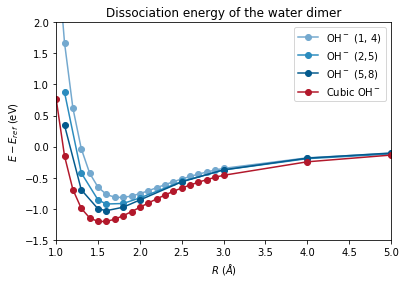

In [36]:
# List of data to be plotted
curves = [OHm, OHm_2_5, cubic_OHm]
curves = [OHm, OHm_2_5, OHm_5_8, cubic_OHm]
# Update legend
OHm['legend'] = 'OH$^-$ (1, 4)'
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#b2182b']
markers = ['o']*4+['s']+['^']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.5, 2.0])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

###### Vary *nbasis* for the OH fragment without CDFT

The behaviour is the same starting from the OH fragment, except that there is a convergence problem for the smallest *nbasis* parameters.

In [37]:
archive = None
OH_m_2_5 = find_data("OH-/oh-/template_tests/nb_2-5/dimer_*/log-*yaml", 'OH + e$^-$ (2, 5)', archive=archive)
OH_m_5_8 = find_data("OH-/oh-/template_tests/nb_5-8/dimer_*/log-*yaml", 'OH + e$^-$ (5, 8)', archive=archive)

OH + e$^-$ (2, 5)
OH + e$^-$ (5, 8)


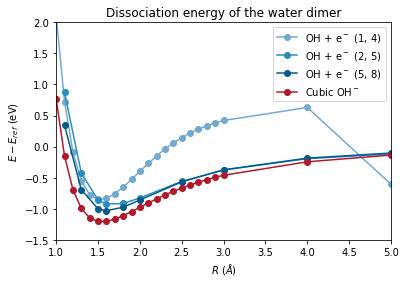

In [38]:
# List of data to be plotted
curves = [OH_m, OH_m_2_5, OH_m_5_8, cubic_OHm]
# Update legend
OH_m['legend'] = 'OH + e$^-$ (1, 4)'
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#b2182b']
markers = ['o']*4+['s']+['^']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.5, 2.0])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

###### Compare OH and OH$^-$ without CDFT
This plot sums up what has been found using the OH and OH$^-$ fragments without CDFT, showing that there is no difference between both calculations, except for the problematic OH calculation with *nbasis* = (1,4) is problematic.

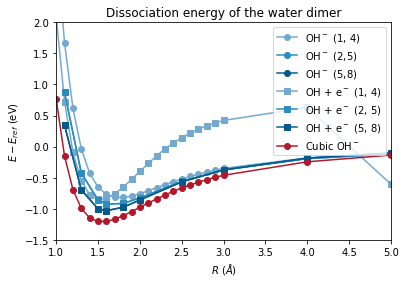

In [39]:
# List of data to be plotted
curves = [OHm, OHm_2_5, OHm_5_8, OH_m, OH_m_2_5, OH_m_5_8, cubic_OHm]
# Update legend
OH_m['legend'] = 'OH + e$^-$ (1, 4)'
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d']*2 + ['#b2182b']
markers = ['o']*3+['s']*3+['o']
# Plot the data using matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], ls='-', label=data['legend'], color=colors[i])
plt.ylim([-1.5, 2.0])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend()
plt.show()

## Some functions that might become useful someday

In [40]:
def shift_positions(struct):
    """
    Function that returns a structure with the positions 
    shifted back to the initial posinp. 
    Works only when units are in angstroem.
    """
    if struct['Units'] != 'angstroem':
        raise ValueError('Units must ne in angstroem')
    au_to_angs = 0.529177249
    new_struct = {}
    #Find the shift, and convert it to angstroem
    shift = [shift*au_to_angs 
             for shift in struct['Rigid Shift Applied (AU)']]
    #Loop over each atom in the structure
    new_pos = []
    for elem in struct['Positions']:
        for at, pos in elem.items():
            pos = [pos[i]-shift[i] for i in range(3)]
            new_pos.append({at: pos})
    new_struct['Positions'] = new_pos
    new_struct['Units'] = 'angstroem'
    new_struct['Rigid Shift Applied (AU)'] = [0.0, 0.0, 0.0]
    return new_struct

In [41]:
# Test of the newly defined function
struct = cubic['logfiles'][0].astruct
print(struct)
#print(struct['Positions'])
new_struct = shift_positions(struct)
print(new_struct)

{'Units': 'angstroem', 'Positions': [{'O': [4.283920014, 4.535053583, 4.072136104]}, {'H': [3.85964432, 4.49839703, 4.914649016]}, {'H': [5.212319619, 4.541508696, 4.243170943]}, {'O': [6.215398014, 4.526799584, 4.302962104]}, {'H': [6.512229014, 5.292627584, 3.837580104]}, {'H': [6.488934014, 3.782761584, 3.790316104]}], 'Rigid Shift Applied (AU)': [9.8557, 8.5614, 7.9169]}
{'Units': 'angstroem', 'Positions': [{'O': [-0.9314921989692992, 0.004555483411399663, -0.11730725860809965]}, {'H': [-1.3557678929692996, -0.032101069588600595, 0.7252056533919005]}, {'H': [-0.0030925939693000615, 0.011010596411400009, 0.053727580391900176]}, {'O': [0.9999858010307001, -0.0036985155886002374, 0.11351874139189988]}, {'H': [1.2968168010307002, 0.7621294844113997, -0.35186325860809964]}, {'H': [1.2735218010307001, -0.7477365155886, -0.39912725860809983]}], 'Rigid Shift Applied (AU)': [0.0, 0.0, 0.0]}


In [42]:
def water_distance_from_paths(paths):
    """
    Function that returns the distance between
    the two water molecules from the paths.
    """
    ##for path in paths:
    ##    print(path, path.split('_'))
    ##    print(path, path.split('_')[-1])
    ##    print(path, float(path.split('_')[-1][:-len('/log-dimer.yaml')]))
    return [float(path.split('_')[-1][:-len('/log-dimer.yaml')]) \
            for path in paths]